[View in Colaboratory](https://colab.research.google.com/github/JohannesFerner/playing-with-tensorflow/blob/master/first.ipynb)

# Data-Preparation for Predicting Bitcoin Price Movements


In [0]:
import tensorflow as tf
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

!pip install -q ta
from ta import *
import timeit



## Goals of this Notebook


*   Import Bitcoin price data
*   Clean Data (**TODO!**)
  *   Add Technical Indicators
  *   Clean out "useless" features  (**TODO!**)
  *   Add calculated Labels to Data
*   Split in Train+Test Data
*   Download Data




## Download, Unzip, Investigate
Following section downloads the 1min BTC Data from my github Repository, unzips, converts to a dataframe and performs a first visualization of the data

In [0]:
# Get the data (stored at my github repository)
from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen
# or: requests.get(url).content

resp = urlopen('https://raw.githubusercontent.com/JohannesFerner/playing-with-tensorflow/master/data/bitstampUSD_1-min_data_2012-01-01_to_2018-03-27.csv.zip')
zipfile = ZipFile(BytesIO(resp.read()))
filenames = zipfile.namelist()

In [42]:
# Seperate code-container, to be easy on github traffic
df = pd.read_csv(zipfile.open(filenames[0]))
# Convert Unix Timestamp to DateTime
df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='s')

# Data Exploration
df.info()

print('First Data')
df.head()

print('Latest Data')
df.tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3273377 entries, 0 to 3273376
Data columns (total 8 columns):
Timestamp            datetime64[ns]
Open                 float64
High                 float64
Low                  float64
Close                float64
Volume_(BTC)         float64
Volume_(Currency)    float64
Weighted_Price       float64
dtypes: datetime64[ns](1), float64(7)
memory usage: 199.8 MB
First Data
Latest Data


,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
3273372,2018-03-26 23:56:00,8159.21,8159.39,8153.62,8153.68,0.663192,5408.215377,8154.826880
3273373,2018-03-26 23:57:00,8159.38,8163.72,8152.81,8155.00,3.720024,30333.753144,8154.182788
3273374,2018-03-26 23:58:00,8157.47,8158.60,8130.01,8130.01,27.294436,222388.761970,8147.769162
3273375,2018-03-26 23:59:00,8145.17,8149.66,8130.01,8149.66,23.065281,187570.784940,8132.169837
3273376,2018-03-27 00:00:00,8152.26,8164.68,8151.37,8153.04,17.758130,144820.147410,8155.146220


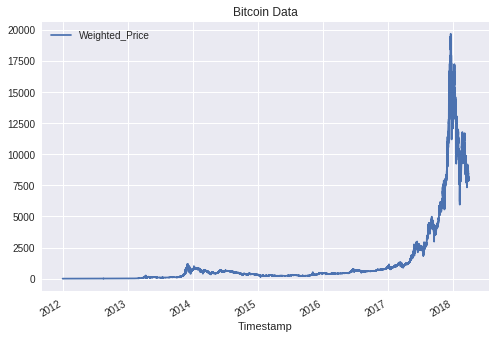

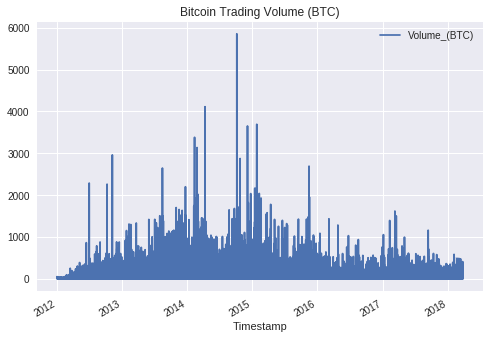

In [43]:
df.plot(y='Weighted_Price', x='Timestamp', title='Bitcoin Data')
df.plot(y='Volume_(BTC)', x='Timestamp', title='Bitcoin Trading Volume (BTC)')

# Data-Preparation 

the following sections shrink the used dataset to 2017 onwards, performs technical indicator calculations, performs label calculations

In [0]:
#1483228800 = 2017-01-01 00:00

bitcoindata = df.loc[2625376::]
del df #safe some memory

In [45]:
# Resampling to 5min Data
bitcoindata.tail()
print('resampling started')
bitcoindata = bitcoindata.resample('5Min').agg({
        'Open': 'first',
        'High': 'max',
        'Low': 'min',
        'Close': 'last',
        'Volume_(BTC)': 'sum',
        'Volume_(Currency)': 'sum',
        'Weighted_Price': 'avg' 
})
bitcoindata.tail()

resampling started


TypeError: ignored

## Add Technical Indicators
https://github.com/bukosabino/ta package used

In [28]:
# Add bollinger band high indicator filling NaN values
#bitcoindata['bb_high_indicator'] = bollinger_hband_indicator(bitcoindata["Close"], n=20, ndev=2, fillna=True)

# Add bollinger band low indicator filling NaN values
#bitcoindata['bb_low_indicator'] = bollinger_lband_indicator(bitcoindata["Close"], n=20, ndev=2, fillna=True)

bitcoindata = add_all_ta_features(bitcoindata, "Open", "High", "Low", "Close", "Volume_(BTC)",
                                fillna=True)


bitcoindata.head()
bitcoindata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 648001 entries, 2625376 to 3273376
Data columns (total 56 columns):
Timestamp            648001 non-null datetime64[ns]
Open                 648001 non-null float64
High                 648001 non-null float64
Low                  648001 non-null float64
Close                648001 non-null float64
Volume_(BTC)         648001 non-null float64
Volume_(Currency)    648001 non-null float64
Weighted_Price       648001 non-null float64
volume1              648001 non-null float64
volume2              648001 non-null float64
volume3              648001 non-null float64
volume5              648001 non-null float64
volume6              648001 non-null float64
volume7              648001 non-null float64
volume8              648001 non-null float64
volatility1          648001 non-null float64
volatility2          648001 non-null float64
volatility3          648001 non-null float64
volatility4          648001 non-null float64
volatility5         

In [0]:
fillna = True
#bitcoindata['adx'] = adx(bitcoindata["High"], bitcoindata["Low"], bitcoindata["Close"], n=14, fillna=fillna)
#bitcoindata['adx_pos'] = adx_pos(bitcoindata["High"], bitcoindata["Low"], bitcoindata["Close"], n=14, fillna=fillna)
#bitcoindata['adx_neg'] = adx_neg(bitcoindata["High"], bitcoindata["Low"], bitcoindata["Close"], n=14, fillna=fillna)
#bitcoindata['adx_indicator'] = adx_indicator(bitcoindata["High"], bitcoindata["Low"], bitcoindata["Close"], n=14, fillna=fillna)

bitcoindata.rename(columns={'volume1': 'acc_dist_index', 
                   'volume2': 'on_balance_volume', 
                   'volume3': 'on_balance_volume_mean',
                   'volume5': 'chaikin_money_flow',
                   'volume6': 'force_index',
                   'volume7': 'ease_of_movement',
                   'volume8': 'volume_price_trend',
                   'volatility1': 'average_true_range', 
                   'volatility2': 'bollinger_hband',
                   'volatility3': 'bollinger_lband',
                   'volatility4': 'bollinger_mavg',
                   'volatility5': 'bollinger_hband_indicator',
                   'volatility6': 'bollinger_lband_indicator',
                   'volatility7': 'keltner_channel_central',
                   'volatility8': 'keltner_channel_hband',
                   'volatility9': 'keltner_channel_lband',
                   'volatility10': 'keltner_channel_hband_indicator',
                   'volatility11': 'keltner_channel_lband_indicator',
                   'volatility12': 'donchian_channel_hband',
                   'volatility13': 'donchian_channel_lband',
                   'volatility14': 'donchian_channel_hband_indicator',
                   'volatility15': 'donchian_channel_lband_indicator',
                   'trend1': 'macd',
                   'trend2': 'macd_signal',
                   'trend3': 'macd_diff',
                   'trend4': 'ema_fast',
                   'trend5': 'ema_slow',
                   'trend6': 'adx',
                   'trend7': 'adx_pos',
                   'trend8': 'adx_neg',
                   'trend9': 'adx_indicator',
                   'trend10': 'vortex_indicator_pos',
                   'trend11': 'vortex_indicator_neg',
                   'trend12': 'vortex_diff',
                   'trend13': 'trix',
                   'trend14': 'mass_index',
                   'trend15': 'cci',
                   'trend16': 'dpo',
                   'trend17': 'kst',
                   'trend18': 'kst_sig',
                   'trend19': 'kst_diff',
                   'trend20': 'ichimoku_a',
                   'trend21': 'ichimoku_b',
                   'momentum1': 'rsi',
                   'momentum2': 'money_flow_index',
                   'momentum3': 'tsi',
                   'others1': 'daily_return',
                   'others2': 'cumulative_return'},
          
          
          inplace=True)


In [34]:
bitcoindata.tail()


,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,acc_dist_index,on_balance_volume,...,kst,kst_sig,kst_diff,ichimoku_a,ichimoku_b,rsi,money_flow_index,tsi,daily_return,cumulative_return
3273372,2018-03-26 23:56:00,8159.21,8159.39,8153.62,8153.68,0.663192,5408.215377,8154.826880,-1.280770,-0.663192,...,-3.533851,-3.715821,0.181970,8227.6000,8216.68,41.435899,32.386267,-1.388953,-0.091042,743.804202
3273373,2018-03-26 23:57:00,8159.38,8163.72,8152.81,8155.00,3.720024,30333.753144,8154.182788,-2.875958,3.720024,...,-3.570675,-3.703539,0.132864,8228.1750,8216.68,42.090744,43.314870,-1.821894,0.016189,743.940805
3273374,2018-03-26 23:58:00,8157.47,8158.60,8130.01,8130.01,27.294436,222388.761970,8147.769162,-29.520994,-27.294436,...,-3.628439,-3.681367,0.052928,8228.1750,8216.68,34.309095,21.286463,-2.863072,-0.306438,741.354652
3273375,2018-03-26 23:59:00,8145.17,8149.66,8130.01,8149.66,23.065281,187570.784940,8132.169837,-4.229154,23.065281,...,-3.605858,-3.632189,0.026331,8222.3350,8216.68,43.161956,40.392668,-3.264910,0.241697,743.388182
3273376,2018-03-27 00:00:00,8152.26,8164.68,8151.37,8153.04,17.758130,144820.147410,8155.146220,9.763361,17.758130,...,-3.545887,-3.583431,0.037544,8218.2225,8216.68,44.539420,54.351100,-3.533288,0.041474,743.737970


In [36]:
bitcoindata.drop(columns=['cumulative_return'])


,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,acc_dist_index,on_balance_volume,...,dpo,kst,kst_sig,kst_diff,ichimoku_a,ichimoku_b,rsi,money_flow_index,tsi,daily_return
2625376,2017-01-01 00:00:00,966.20,966.30,966.20,966.30,2.004084,1936.447714,966.250860,0.000000,0.000000,...,0.0000,0.000000,0.000000,0.000000,965.6475,965.790,50.000000,50.000000,0.000000,0.000000
2625377,2017-01-01 00:01:00,966.34,966.34,966.34,966.34,7.610000,7353.847400,966.340000,2.004084,7.610000,...,0.0000,0.000000,0.000000,0.000000,965.6475,965.790,100.000000,50.000000,100.000000,0.004140
2625378,2017-01-01 00:02:00,966.16,966.37,966.16,966.37,8.087376,7814.876061,966.305479,8.087376,8.087376,...,0.0000,0.000000,0.000000,0.000000,965.6475,965.790,100.000000,50.000000,100.000000,0.003104
2625379,2017-01-01 00:03:00,966.16,966.37,966.16,966.37,8.087376,7814.876061,966.305479,16.174753,0.000000,...,0.0000,0.000000,0.000000,0.000000,965.6475,965.790,100.000000,50.000000,100.000000,0.000000
2625380,2017-01-01 00:04:00,966.16,966.37,966.16,966.37,8.087376,7814.876061,966.305479,16.174753,0.000000,...,0.0000,0.000000,0.000000,0.000000,965.6475,965.790,100.000000,50.000000,100.000000,0.000000
2625381,2017-01-01 00:05:00,966.43,966.43,966.43,966.43,0.107000,103.408010,966.430000,8.087376,0.107000,...,0.0000,0.000000,0.000000,0.000000,965.6475,965.790,100.000000,50.000000,100.000000,0.006209
2625382,2017-01-01 00:06:00,966.58,966.58,966.58,966.58,0.331732,320.645952,966.580000,0.000000,0.331732,...,0.0000,0.000000,0.000000,0.000000,965.6475,965.790,100.000000,50.000000,100.000000,0.015521
2625383,2017-01-01 00:07:00,966.58,966.58,966.58,966.58,0.331732,320.645952,966.580000,0.000000,0.000000,...,0.0000,0.000000,0.000000,0.000000,965.6475,965.790,100.000000,50.000000,100.000000,0.000000
2625384,2017-01-01 00:08:00,966.58,966.58,966.58,966.58,0.331732,320.645952,966.580000,0.000000,0.000000,...,0.0000,0.000000,0.000000,0.000000,965.6475,965.790,100.000000,50.000000,100.000000,0.000000
2625385,2017-01-01 00:09:00,966.58,966.58,966.58,966.58,0.331732,320.645952,966.580000,0.000000,0.000000,...,0.0000,0.000000,0.000000,0.000000,965.6475,965.790,100.000000,50.000000,100.000000,0.000000


## Add Labels to Data

As this data is intented to be used in a classification ML Model which should predict the possibility of a certain price-movement in percent-ranges this features have to be calculated on the historical data

In [8]:
firstIndex = bitcoindata.first_valid_index()

bitcoindata[firstIndex::]

#Labels to Add: 
# Boolean: WentUp
# Boolean: WendDown
# Boolean: 1-3%
# Boolean: -1-3%


,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,bb_high_indicator,bb_low_indicator,adx,adx_pos,adx_neg,adx_indicator


# Split in Train Test

Split Data into 70% Test, 30% Test and visualize in order to detect problems easily (Hint: ``` shuffle=False ```)


,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,bb_high_indicator,bb_low_indicator,adx,adx_pos,adx_neg,adx_indicator
3273372,2018-03-26 23:56:00,8159.21,8159.39,8153.62,8153.68,0.663192,5408.215377,8154.826880,0.0,0.0,32.649426,18.646710,16.752417,1
3273373,2018-03-26 23:57:00,8159.38,8163.72,8152.81,8155.00,3.720024,30333.753144,8154.182788,0.0,0.0,31.378843,22.730930,17.291600,1
3273374,2018-03-26 23:58:00,8157.47,8158.60,8130.01,8130.01,27.294436,222388.761970,8147.769162,0.0,1.0,30.722831,19.390487,30.036379,0
3273375,2018-03-26 23:59:00,8145.17,8149.66,8130.01,8149.66,23.065281,187570.784940,8132.169837,0.0,0.0,31.153222,12.946573,28.270560,0
3273376,2018-03-27 00:00:00,8152.26,8164.68,8151.37,8153.04,17.758130,144820.147410,8155.146220,0.0,0.0,30.779587,16.527610,27.870836,0


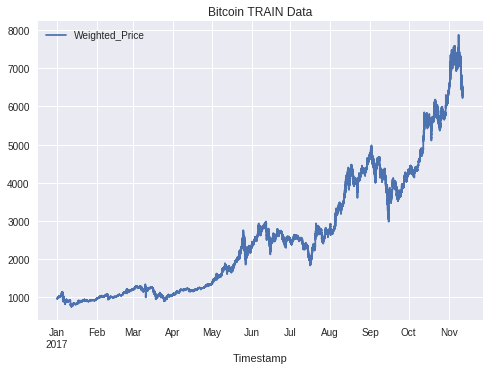

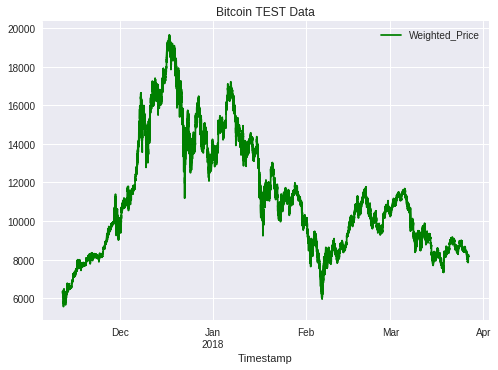

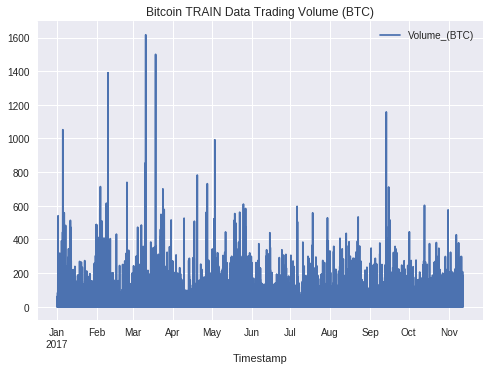

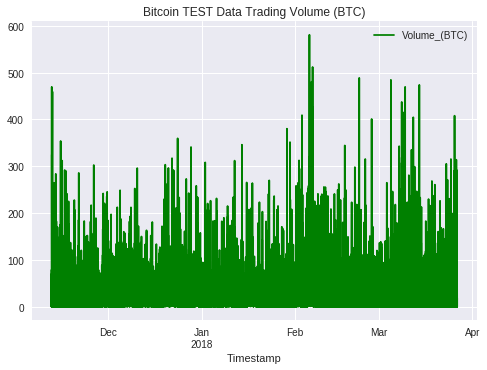

In [9]:


from sklearn.model_selection import train_test_split

# Split Data into 70% Test, 30% Test
train, test = train_test_split(bitcoindata, test_size=0.3, shuffle=False) 
#Visualization is a good idea, i didn't know about the train_test_split shuffle parameter before

train.plot(y='Weighted_Price', x='Timestamp', title='Bitcoin TRAIN Data')
test.plot(y='Weighted_Price', x='Timestamp', title='Bitcoin TEST Data', color='g')

train.plot(y='Volume_(BTC)', x='Timestamp', title='Bitcoin TRAIN Data Trading Volume (BTC)')
test.plot(y='Volume_(BTC)', x='Timestamp', title='Bitcoin TEST Data Trading Volume (BTC)', color='g')


test.tail()


# Download Data

The following section will zip the train and test data as CSV and provide a download 

In [10]:
from google.colab import files

bitcoindata.to_csv('df.csv')

print('creating archive')
zf = ZipFile('df.zip', mode='w')
try:
    print('adding df.csv')
    zf.write('df.csv')
finally:
    print('closing')
    zf.close()
    
files.download('df.zip')


import datetime

def print_info(archive_name):
    zf = ZipFile(archive_name)
    for info in zf.infolist():
        print(info.filename)
        print('\tComment:\t', info.comment)
        print('\tModified:\t', datetime.datetime(*info.date_time))
        print('\tSystem:\t\t', info.create_system, '(0 = Windows, 3 = Unix)')
        print('\tZIP version:\t', info.create_version)
        print('\tCompressed:\t', info.compress_size, 'bytes')
        print('\tUncompressed:\t', info.file_size, 'bytes')
        print('')


print_info('df.zip')

creating archive
adding df.csv
closing
df.csv
	Comment:	 b''
	Modified:	 2018-06-03 13:58:06
	System:		 3 (0 = Windows, 3 = Unix)
	ZIP version:	 20
	Compressed:	 105773014 bytes
	Uncompressed:	 105773014 bytes

